In [1]:
from src.image_captioner import ImageCaptionerTorchscript, ImageCaptioner
import torch
import logging
from PIL import Image
logging.basicConfig(level=logging.INFO)

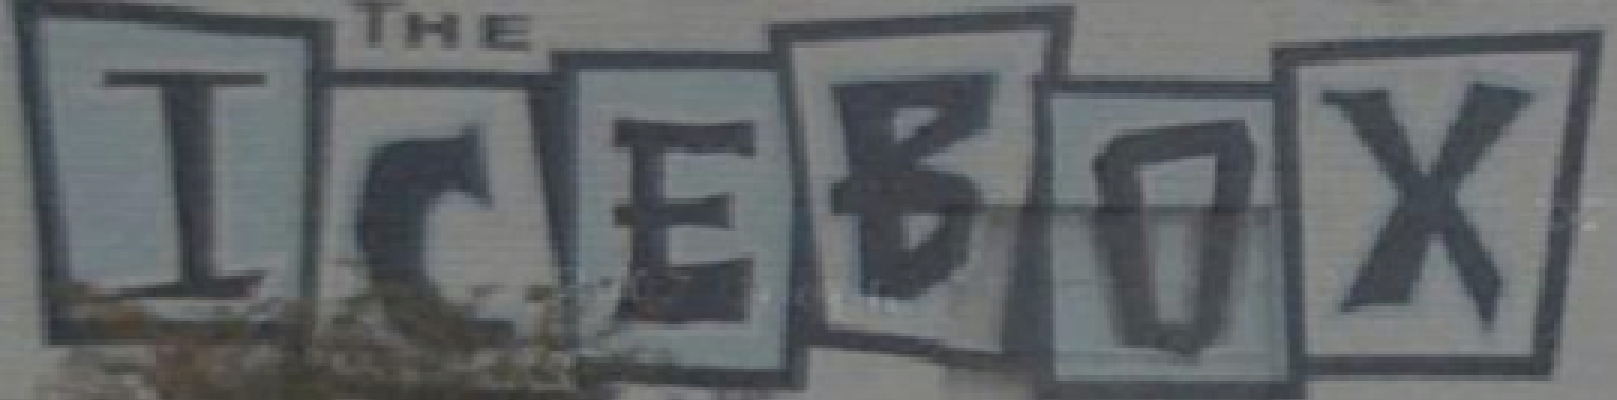

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
path_to_image = 'imgs/raw_img_example/image.png'
Image.open(path_to_image)

# PyTorch model (FP32 / FP16 / BF16)

In [3]:
pt_model = ImageCaptioner(
    checkpoint_path='ViTSTR-FP32.ckpt',
    device=device
)
output = pt_model.caption_image(path_to_image, save_img=False)
print(output)

icebox


# TorchScript model (FP16 / BF16)

In [ ]:
ts_model = ImageCaptionerTorchscript(
    checkpoint_path='ViTSTR-BF16.torchscript', 
    labels=r"!%&,-./0123456789=_abcdefghijklmnopqrstuvwxyz",
    device=device,
    dtype=torch.bfloat16
)
processed_img = ts_model.preprocess_image(path_to_image)
output = ts_model.predict(processed_img)
print(output)

INFO:src.image_captioner:Inference time: 0.37 seconds


icebox
